In [1]:
%matplotlib inline

In [2]:
import numpy as np
from scipy import sparse
import matplotlib.pyplot as plt
import pygsp
from pygsp import graphs, filters
import networkx as nx

In [88]:
#Gnx = nx.read_gpickle('StanLee.gpickle')
#seed = 'Stan Lee'

Gnx = nx.read_gpickle('StephenHawking.gpickle')
seed = 'Stephen Hawking'

#Gnx = nx.read_gpickle('AlanRickman.gpickle')
#seed = 'Alan Rickman'

In [89]:
len(Gnx.nodes), len(Gnx.edges)

(100, 255)

In [90]:
Gnx.node[seed]

{'delta': 451.5704961662759}

In [91]:
nodes = np.array(Gnx.nodes())
delta = nx.get_node_attributes(Gnx, 'delta')
signal = np.array([delta[n] for n in nodes])

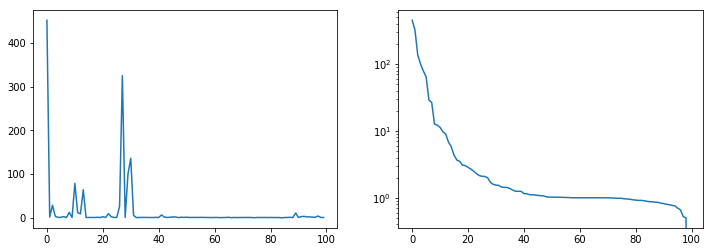

In [92]:
fig = plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(signal)
plt.subplot(1,2,2)
plt.semilogy(sorted(signal, reverse=True))

In [93]:
# look at what pages got the highest delta
list(zip(nodes[signal>2],signal[signal>2]))

[('Stephen Hawking', 451.5704961662759),
 ('Trinity Hall, Cambridge', 28.955882352941178),
 ('Bantam Books', 3.6594202898550723),
 ('American Physical Society', 3.0720720720720722),
 ('Peter Higgs', 12.648725212464589),
 ('The Theory of Everything (2014 film)', 78.90278354798504),
 ('University College, Oxford', 12.193251533742332),
 ('Kip Thorne', 8.998614958448753),
 ('Lilienfeld Prize', 64.27272727272727),
 ('Royal Society', 2.6886005560704356),
 ('Weston Library', 9.68421052631579),
 ('The Sunday Times', 2.8511166253101736),
 ('Tariq Ali', 26.58823529411765),
 ('Bruce Allen (physicist)', 324.84313725490193),
 ('Hawking (2004 film)', 99.82352941176471),
 ('Adams Prize', 136.52272727272728),
 ('Pride of Britain Awards', 5.777777777777778),
 ('William Bateman', 6.8),
 ('Peter Millett, Baron Millett', 2.090909090909091),
 ('Tom James', 2.0869565217391304),
 ('Jeremy Morris', 2.1538461538461537),
 ('Albert Einstein', 11.263721912809679),
 ('Sakurai Prize', 3.033333333333333),
 ('Einstei

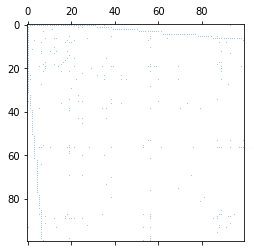

In [94]:
# make graph undirected & remove self loops
A = nx.adjacency_matrix(Gnx).todense()
A = np.logical_or(A, A.T).astype(int)
np.fill_diagonal(A, 0)
A = np.array(A)
adjacency = sparse.csr_matrix(A)

plt.spy(adjacency, markersize=0.1)

In [95]:
#sparse.csr_matrix(A)
n_nodes = A.shape[0]
D = sparse.diags(np.sum(A, axis=0))
D_inv_sq = sparse.diags(1 / np.sqrt(np.sum(A,axis=0)))
laplacian_combinatorial = D - adjacency
laplacian_normalized = sparse.eye(n_nodes) - D_inv_sq @ adjacency @ D_inv_sq.T

In [96]:
#eig_val, U = np.linalg.eigh(laplacian_normalized)
eig_val, U = sparse.linalg.eigsh(laplacian_normalized, k=20, which='SM')
U_norm = D_inv_sq @ U # renormalize for eigenmap visualizatio
eigenmap = U[:,1:3]

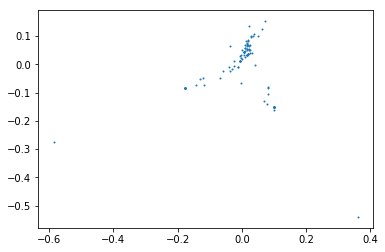

In [97]:
plt.scatter(U[:, 1], U[:, 2], s=1)

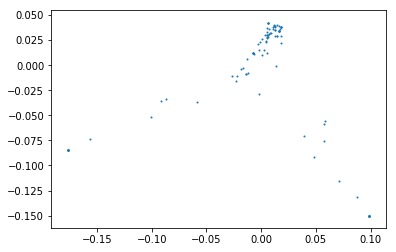

In [98]:
plt.scatter(U_norm[:, 1], U_norm[:, 2], s=1)

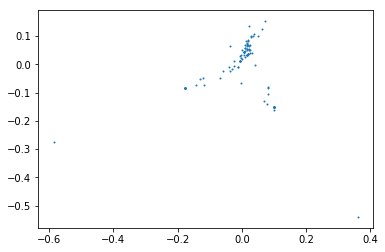

In [99]:
#G = pygsp.graphs.Graph(adjacency, lap_type='combinatorial')
G = pygsp.graphs.Graph(sparse.csr_matrix(A), lap_type='normalized')
eig_val, U = sparse.linalg.eigsh(G.L, k=20, which='SM')
plt.scatter(U[:, 1], U[:, 2], s=1)

In [100]:
#G.set_coordinates(kind='spring')
G.set_coordinates(U[:,1:3])

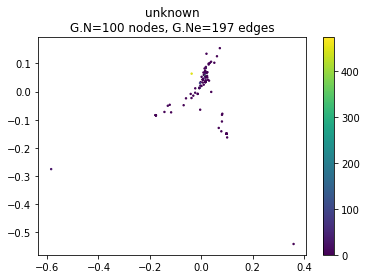

In [101]:
G.plot_signal(signal, vertex_size=2, show_edges=False)

In [102]:
eigenval_comb, eigen_vec_comb = np.linalg.eigh(laplacian_combinatorial.toarray())

In [103]:
e, U = eigenval_comb, eigen_vec_comb

def GFT(x):
    return  np.matmul(U.T,x) # U.T= U^-1 because orthonormal 

def iGFT(x):
    return np.matmul(U,x) 

def heat_kernel(e, t):
    return np.exp(-t*e)

def inverse_kernel(e, t):
    g = 1/(1 + t*e)
    return g

def rectangle_kernel(e, l_min, l_max):
    cond = np.logical_and(e >= l_min, e <= l_max)
    return np.where(cond, 1, 0)

def graph_filter(x, kernel, **kwargs):
    e = eigenval_comb
    g = kernel(e, **kwargs)
    return iGFT(np.matmul(np.diag(g),GFT(x)))

In [104]:
dirac = np.zeros(n_nodes);
dirac[nodes==seed] = 1;

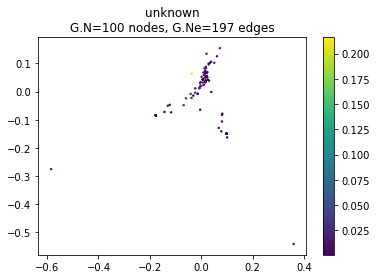

In [105]:
x = graph_filter(dirac, heat_kernel, t=0.05)
G.plot_signal(x, vertex_size=2, show_edges=False)

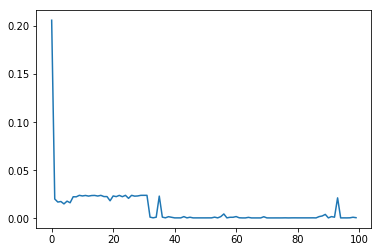

In [106]:
plt.plot(x)

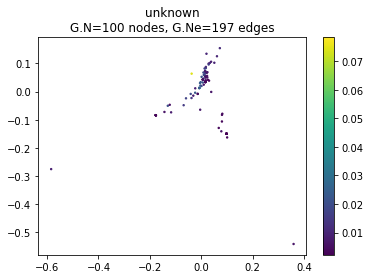

In [107]:
x = graph_filter(dirac, inverse_kernel, t=0.5)
G.plot_signal(x, vertex_size=2, show_edges=False)

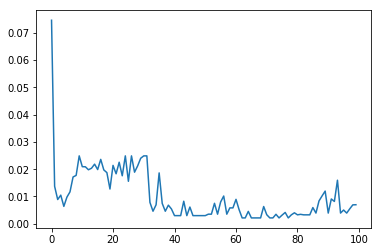

In [108]:
plt.plot(x)